# translating matlab code parser

## setup

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import time

from itertools import groupby
from collections import Counter
from operator import itemgetter

from tqdm import tqdm_notebook, tnrange

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid',rc={'figure.facecolor':'#abb2bf'})

## params

In [7]:
# paths
#lvm_path = Path(r'data/qim_20kbps_10db_l2_v2.lvm')
#lvm_path = Path(r'data/test_packet.lvm')
lvm_path = Path(r'data/test_data_v2_converted.csv')

## class building

In [109]:
class DataParserLVM:
    def __init__(self, lvm_path, source='txt', header=None, preprocess_mode='static'):
        print('initializing..')
        
        # set input path
        if isinstance(lvm_path, Path):
            try: 
                assert lvm_path.exists()
                self.lvm_path = lvm_path
                print(f'\tset input lvm path: {self.lvm_path}')
            except AssertionError:
                print(f'no file found at {lvm_path}')
                raise                
        else:
            print(f'invalid path {lvm_path}, must be pathlib.Path object')
            raise TypeError
                
        # header
        if header is None:
            #self.header = np.array([1 if i % 2 == 0 else 0 for i in range(30)])
            self.header = np.ones(50, dtype=int)
            print(f'\tset header: {self.header}')
        else:
            if isinstance(header, list):
                self.header = np.array(header)
                print(f'\tset header: {self.header}')
            elif isinstance(header, np.ndarray):
                self.header = header
                print(f'\tset header: {self.header}')
            else:
                print(
                    f'invalid header format specified ({type(header)}), ' + 
                    f'must be np.array or list'
                )
                raise TypeError
        
        # source
        if source == 'txt':
            self.parse_other_file()
        elif source == 'lvm':
            self.parse_lvm_file()
            self.read_processed_csv_data()
        elif source == 'csv':
            self.read_csv_data(skiprows=0)
        else:
            print(
                f'invalid source {source}, options are ' + 
                '\'txt\' for tab delimited numbers only or ' + 
                '\'lvm\' for lvm file with headers or ' + 
                '\'csv\' for csv file with no headers, just data'
            )
            
        # data message
        #self.data_msg = self.create_data_message()
        self.data_msg = np.array([1,0,0,1,0,1,0,1,1,0])
        self.transitioned_data_msg = np.array([1,0,0,0,1])
        print(f'created data message, {self.data_msg.size} bits')
        
        # startup tasks
        self.preprocess_data(mode=preprocess_mode)
        
    #------------------------------ ingestion and processing ------------------------------
    def create_data_message(self):
        scaler = 1
        base = np.array([1 if i % 2 == 0 else 0 for i in range(20)])
        
        return np.concatenate((
            np.repeat(base, scaler), 
            np.repeat(base, scaler), 
            np.repeat(base, 2*scaler), 
            np.repeat(base, scaler), 
            np.repeat(base, scaler), 
            np.repeat(base, 2*scaler)
        ))
        
        
    def parse_other_file(self):
        print('parsing tab delimited file..')
        self.raw_data = np.genfromtxt(
            self.lvm_path,
            delimiter='\t',
            usecols=(1)
        )        
        print(f'\timported data, {self.raw_data.size} rows')
        
            
    def parse_lvm_file(self, output_path='auto'):
        """
        reads in .lvm file, writes out .csv with column names
        containing only data points
        
        [arguments]
        input_path: str or pathlib.Path object (preferred)
            input file path
        output_path: 'auto' (preferred) or str or pathlib.Path object
            if auto:
                appends _parsed.csv to end of input file name
            else:
                use provided path, must end in .csv
                
        [returns]
        None
            outputs parsed lvm file
            sets self.parsed_lvm_path, pathlib.Path object pointing to parsed file
        """
        
        print('parsing lvm file..')
        with open(self.lvm_path, 'r') as infile:
            # set output path
            file_name = infile.name
            
            if output_path == 'auto':
                self.parsed_lvm_path = Path(f'{file_name}_parsed.csv')
            else:
                self.parsed_lvm_path = output_path
                
                if isinstance(parsed_lvm_path, Path):
                    try:
                        assert str(parsed_lvm_path).endswith('.csv')
                    except AssertionError:
                        print('output file must end with .csv')
                        raise
                elif isinstance(parsed_lvm_path, str):
                    try:
                        assert parsed_lvm_path.endswith('.csv')
                    except AssertionError:
                        print('output file must end with .csv')
                        raise
                else:
                    print('error, output_path must be str or pathlib.Path object')
                    raise TypeError
            
            if not self.parsed_lvm_path.exists():
                self.parsed_lvm_path.touch()
            
            # find header, store column names
            while True:
                line = infile.readline()
                
                if line.strip().endswith('Comment'):
                    cols = line.split(',')[:-1]
                    print(f'\tcolumns: {cols}')
                    break        
                    
            # trim file and write out
            with open(self.parsed_lvm_path, 'w') as outfile:
                outfile.write(', '.join(cols) + '\n')
                while True:
                    try:
                        outfile.write(next(infile))
                    except StopIteration:
                        break
        
        print(f'\tcomplete, parsed file saved to: {self.parsed_lvm_path}')
        
    def read_processed_csv_data(self):
        print('importing data from parsed csv..')
        self.raw_data = np.genfromtxt(
            self.parsed_lvm_path,
            delimiter=',',
            skip_header=1,
            usecols=(1)
        )
        
        print(f'\timported data, {self.raw_data.size} rows')
        
    def read_csv_data(self, skiprows):
        print('importing data from csv..')
        self.raw_data = np.genfromtxt(
            self.lvm_path,
            delimiter=',',
            skip_header=skiprows,
            usecols=(1)
        )
        
        print(f'\timported data, {self.raw_data.size} rows')
        
        
    def preprocess_data(self, mode='static'):
        """
        convert float data into 1's and 0's
        
        static: use 1/2 * max data point as threshold
        dynamic: use min + 1/2(max - min) as threshold
        """
        
        if mode == 'static':
            th = self.raw_data.max() / 2
        elif mode == 'dynamic':
            th = self.raw_data.min() + (self.raw_data.max() - self.raw_data.min()) / 2
        else:
            print(f'invalid mode {mode}, options are \'static\' or \'dynamic\'')        
        
        shape_check = self.raw_data[np.where(self.raw_data >= th)].size
        
        self.raw_data[np.where(self.raw_data >= th)] = 1
        self.raw_data[np.where(self.raw_data < th)] = 0
        
        # set dtype and store
        self.data = self.raw_data.astype('int')[7:]
        
        # validate
        try:
            assert self.data.sum() == shape_check            
        except AssertionError:
            print(
                f'error: sum of 1\'s ({self.data.sum()}) does not match ' + 
                f'number of entries >= th ({shape_check})'
            )
        
    #---------------------------------- discretization methods ----------------------------------    
    def get_state_length_list(self, data):
        '''
        takes data list ([1,1,0,1,0,0,...]) and returns numpy array 
        of duration of consecutive bits ([13,245,2588,19,1056,...])
        '''
        
        return np.diff(
            np.where(
                np.concatenate(
                    ([data[0]],
                     data[:-1] != data[1:],
                     [0]
                    )
                )
            )[0]
        )[::2]
    
    def get_correct_state_length_list(self, data):
        '''
        gets state lengths like above, but correctly..
        '''
        
        groups = groupby(data)
        
        return [sum(1 for _ in group) for _, group in groups]
    

    def discretize_signal(self, spb=12):
        start_time = time.time()
        print('discretizing signal..')
        
        # set params
        self.spb = spb
        
        discretized_data = []
        start_bit = self.data[0]
        alt_bit = 0 if start_bit == 1 else 1
        print(f'\tstarting bit: {start_bit}, alt bit: {alt_bit}')
        
        # get state lengths
        #state_lengths = self.get_state_length_list(self.data)
        state_lengths = self.get_correct_state_length_list(self.data)
        
        for i, state in enumerate(state_lengths):
            discretized_state = int(np.round(state / self.spb))
            #print(f'iter: {i}, discretized state: {discretized_state}')
            
            if i % 2 == 0:
                discretized_data.append([start_bit for j in range(discretized_state)])
            elif i % 2 == 1:
                discretized_data.append([alt_bit for j in range(discretized_state)])
            else:
                print('ya done messed up.')
        
        self.discretized_array = np.array([
            item for sublist 
                in discretized_data 
            for item in sublist
        ])
        
        reduction = 100 * (self.discretized_array.size / self.data.size)
        print(
            f'\tcomplete, discretized signal: {self.discretized_array.size} entries ' + 
            f'({reduction:0.2f}% of original)\n'
            f'\tprocessing time: {time.time() - start_time:0.4f} sec'
        )
        
    #---------------------------------- search and ber ----------------------------------
    def search_sequence_numpy(self, arr, seq):
        """ 
        find sequence in an array 
    
        Parameters
        ----------    
        arr    : input 1D array
        seq    : input 1D array
    
        Output
        ------    
        Output : array of starting indices of matches
        """
        
        # validate inputs
        try:
            assert isinstance(arr, np.ndarray)
        except AssertionError:
            print(f'input arr must be numpy array, you provided {type(arr)}')
            raise
            
        try:
            assert isinstance(seq, np.ndarray)
        except AssertionError:
            print(f'input seq must be numpy array, you provided {type(arr)}')
            raise
    
        # Store sizes of input array and sequence
        Na, Nseq = arr.size, seq.size
    
        # Range of sequence
        r_seq = np.arange(Nseq)
    
        # Create a 2D array of sliding indices across the entire length of input array.
        # Match up with the input sequence & get the matching starting indices.
        M = (arr[np.arange(Na-Nseq+1)[:, None] + r_seq] == seq).all(1)
    
        # Get the range of those indices as final output
        if M.any() > 0:
            tmp_array =  np.where(
                np.convolve(
                    M,
                    np.ones((Nseq), dtype=int)
                ) > 0
            )[0]
        else:
            tmp_array =  []
        

        match_starting_idxs = [
            list(map(itemgetter(1), g))[0]
            for k, g in groupby(enumerate(tmp_array), lambda ix: ix[0] - ix[1])
        ]
        
        print(f'found {len(match_starting_idxs)} matches')
        
        return match_starting_idxs

        
        
    def get_signal_stats(self, data):
        state_lengths = self.get_correct_state_length_list(data)
        
        return Counter(state_lengths).most_common()
    
    
    def compute_bit_error_rate(self):
        # find headers
        self.header_starts = self.search_sequence_numpy(self.discretized_array, self.header)
        #print(f'found {len(self.header_starts)} headers')
        
        # slice data packets
        self.ber = []
        clipped_packets = 0
        
        for header in self.header_starts:
            start = header + len(self.header) + 4
            stop = start + len(self.data_msg)
            
            if self.discretized_array[start:stop].size == 160:
                data_slice = self.discretized_array[start:stop]
                self.ber.append((data_slice - self.data_msg).sum())
            else:
                clipped_packets += 1
                
        print(f'complete, found {clipped_packets} clipped packet(s)')
        print(
            f'bit error breakdown:\n' + 
            f'\ttotal messages computed: {len(self.ber)}\n' + 
            f'\tcumulative bit errors: {sum(self.ber)}\n' + 
            f'\tmean bit errors: {sum(self.ber) / len(self.ber)}\n' + 
            f'\tprobably all zero, if not all bit errors are stored in self.ber'
        )
        
    def compute_bit_error_rate_manchester(self):
        self.ber = []
        clipped_packets = 0
        
        for msg in self.search_sequence_numpy(self.discretized_array, self.data_msg):
            start = msg
            stop = msg + self.data_msg.size
            
            if self.discretized_array[start:stop].size == 10:
                data_slice = self.discretized_array[start:stop]
                
                # transition slice
                converted = self.transition_data(data_slice)
                self.ber.append((converted - self.transitioned_data_msg).sum())
                
            else:
                clipped_packets += 1   
                
        print(f'complete, found {clipped_packets} clipped packet(s)')
        print(
            f'bit error breakdown:\n' + 
            f'\ttotal messages computed: {len(self.ber)}\n' + 
            f'\tcumulative bit errors: {sum(self.ber)}\n' + 
            f'\tmean bit errors: {sum(self.ber) / len(self.ber)}\n' + 
            f'\tprobably all zero, if not all bit errors are stored in self.ber'
        )
        
    def transition_data(self, data):
        new_bits = []
        
        for i, elem in enumerate(data):
            if i % 2 == 0:
                prev = elem
            else:
                # if 1 -> 0
                if elem - prev == -1:
                    new_bits.append(1)
                # if 0 -> 1
                if elem - prev == 1:
                    new_bits.append(0)
                    
        return new_bits
        
        
    #---------------------------------- output methods ----------------------------------
    def output_discretized_array(self, output_path='auto', output_format='csv'):
        # set output path
        if output_path == 'auto':
            output_path = Path(r'data/discretized_array.csv')            
        elif isinstance(output_path, Path):
            try:
                assert output_path.parent.exists()
                assert output_path.name.endswith('.csv')
            except AssertionError:
                print(
                    f'parent path ({output_path.parent}) unavailable or ' + 
                    f'path does not end with .csv ({output_path.name}), ' + 
                    f'please choose another path'
                )
                raise
        elif isinstance(output_path, str):
            try:
                output_path = Path(output_path)
                assert output_path.parent.exists()
                assert output_path.name.endswith('.csv')
            except AssertionError:
                print(
                    f'parent path ({output_path.parent}) unavailable or ' + 
                    f'path does not end with .csv ({output_path.name}), ' + 
                    f'please choose another path'
                )
                raise
        else:
            print(
                f'you really messed up, you provided {output_path} {type(output_path)}, ' + 
                f'please provide output_path as str or pathlib.Path object ending with .csv'
            )            
        print(f'set discretized signal output path: {output_path}')
                
        # output
        if output_format == 'csv':
            np.savetxt(
                output_path,
                self.discretized_array,
                delimiter=','
            )
            print(f'\tsuccessfully saved file to: {output_path}')
        else:
            print(f'yeah.. csv is actually the only option.. please try again.')
            raise TypeError
            
    
    #---------------------------------- plotting methods ----------------------------------
    
    def plot_subset(self, data, start, stop):
        plt.figure(figsize=(20, 6))
        
        plt.stem(data[start:stop])
    
    def compare_plots(self, start, stop, title=None):
        if title is None:
            title='no title provided'
        
        fig, ((ax1, ax2)) = plt.subplots(2, 1, sharex=False, sharey=True, figsize=(15,6))
        
        ax1.stem(DP.data[start*DP.spb:stop*DP.spb])
        ax2.stem(DP.discretized_array[start:stop]) 
        
        ax1.set_title(title)
    
        
        
        

## execution

### main

In [110]:
DP = DataParserLVM(
    lvm_path, 
    source='csv',
    preprocess_mode='dynamic'
)

initializing..
	set input lvm path: data/test_data_v2_converted.csv
	set header: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
importing data from csv..
	imported data, 2100000 rows
created data message, 10 bits


In [111]:
DP.discretize_signal(spb=12)

discretizing signal..
	starting bit: 0, alt bit: 1
	complete, discretized signal: 173655 entries (8.27% of original)
	processing time: 0.4480 sec


In [112]:
DP.compute_bit_error_rate_manchester()

found 4038 matches
complete, found 0 clipped packet(s)
bit error breakdown:
	total messages computed: 4038
	cumulative bit errors: 0
	mean bit errors: 0.0
	probably all zero, if not all bit errors are stored in self.ber


## dev

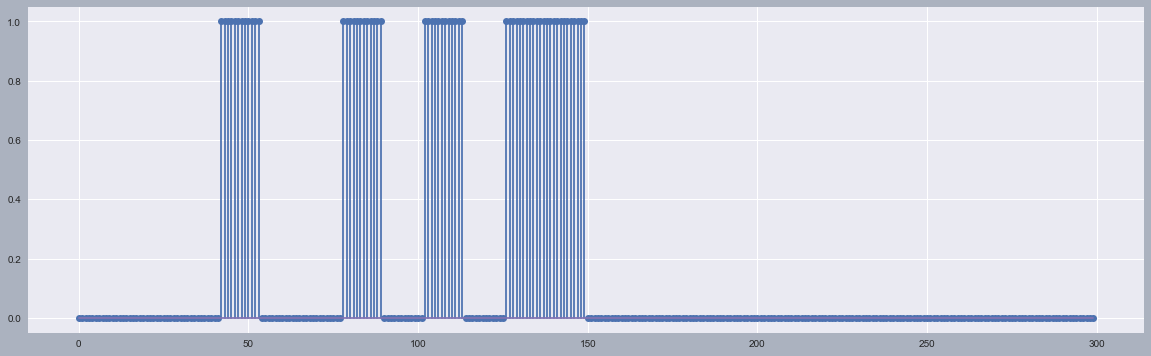

In [18]:
DP.plot_subset(
    DP.data, 
    start=350, 
    stop=650
)

In [20]:
Counter(DP.get_correct_state_length_list(DP.data))

Counter({392: 1,
         12: 19630,
         24: 7834,
         412: 3910,
         11: 249,
         13: 311,
         25: 145,
         411: 127,
         23: 97,
         270: 1})

In [21]:
DP.get_signal_stats(DP.data)

[(12, 19630),
 (24, 7834),
 (412, 3910),
 (13, 311),
 (11, 249),
 (25, 145),
 (411, 127),
 (23, 97),
 (392, 1),
 (270, 1)]

In [22]:
DP.data[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### disc attempt

In [23]:
DP.discretize_signal(spb=12)

discretizing signal..
	starting bit: 0, alt bit: 1
	complete, discretized signal: 173655 entries (8.27% of original)
	processing time: 0.4401 sec


In [24]:
DP.get_signal_stats(DP.discretized_array)

[(1, 20190), (2, 8076), (34, 4037), (33, 1), (22, 1)]

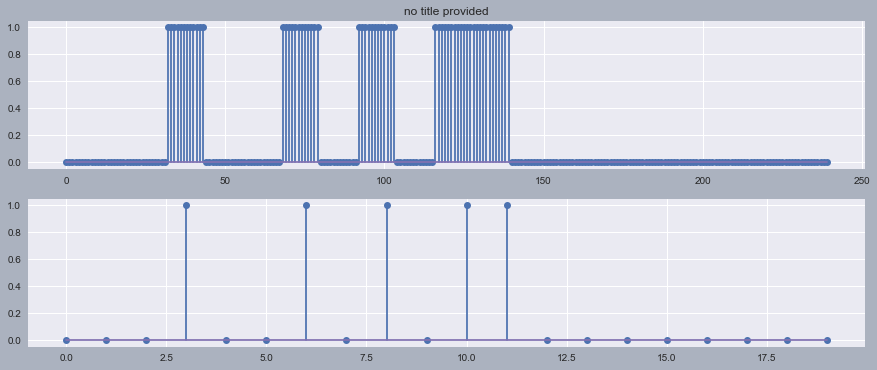

In [30]:
DP.compare_plots(
    30,
    50
)

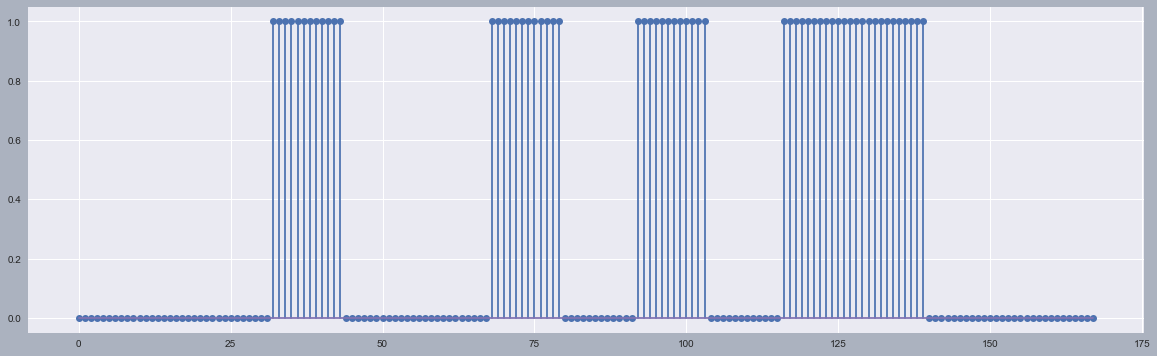

In [35]:
DP.plot_subset(
    DP.data,
    30*12,
    44*12
)

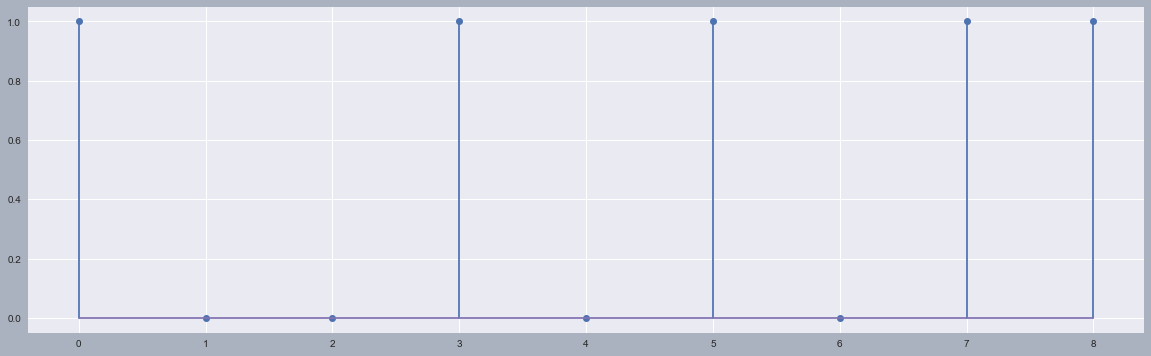

In [42]:
DP.plot_subset(
    DP.discretized_array,
    33,
    42
)

In [43]:
data_msg = [1,0,0,1,0,1,0,1,1]

### finding data

In [58]:
DP.search_sequence_numpy(DP.discretized_array, DP.data_msg)

found 4038 matches


[33,
 76,
 119,
 162,
 205,
 248,
 291,
 334,
 377,
 420,
 463,
 506,
 549,
 592,
 635,
 678,
 721,
 764,
 807,
 850,
 893,
 936,
 979,
 1022,
 1065,
 1108,
 1151,
 1194,
 1237,
 1280,
 1323,
 1366,
 1409,
 1452,
 1495,
 1538,
 1581,
 1624,
 1667,
 1710,
 1753,
 1796,
 1839,
 1882,
 1925,
 1968,
 2011,
 2054,
 2097,
 2140,
 2183,
 2226,
 2269,
 2312,
 2355,
 2398,
 2441,
 2484,
 2527,
 2570,
 2613,
 2656,
 2699,
 2742,
 2785,
 2828,
 2871,
 2914,
 2957,
 3000,
 3043,
 3086,
 3129,
 3172,
 3215,
 3258,
 3301,
 3344,
 3387,
 3430,
 3473,
 3516,
 3559,
 3602,
 3645,
 3688,
 3731,
 3774,
 3817,
 3860,
 3903,
 3946,
 3989,
 4032,
 4075,
 4118,
 4161,
 4204,
 4247,
 4290,
 4333,
 4376,
 4419,
 4462,
 4505,
 4548,
 4591,
 4634,
 4677,
 4720,
 4763,
 4806,
 4849,
 4892,
 4935,
 4978,
 5021,
 5064,
 5107,
 5150,
 5193,
 5236,
 5279,
 5322,
 5365,
 5408,
 5451,
 5494,
 5537,
 5580,
 5623,
 5666,
 5709,
 5752,
 5795,
 5838,
 5881,
 5924,
 5967,
 6010,
 6053,
 6096,
 6139,
 6182,
 6225,
 6268,
 63

In [46]:
DP.discretized_array[33:42]

array([1, 0, 0, 1, 0, 1, 0, 1, 1])

In [47]:
data_msg

[1, 0, 0, 1, 0, 1, 0, 1, 1]

## ber dev

In [ ]:
# slice data packets
self.ber = []
clipped_packets = 0

for header in self.header_starts:
    start = header + len(self.header) + 4
    stop = start + len(self.data_msg)
    
    if self.discretized_array[start:stop].size == 160:
        data_slice = self.discretized_array[start:stop]
        self.ber.append((data_slice - self.data_msg).sum())
    else:
        clipped_packets += 1

In [99]:
def compute_bit_error_rate_new(self):
    self.ber = []
    clipped_packets = 0
    
    for msg in self.search_sequence_numpy(self.discretized_array, self.data_msg):
        start = msg
        stop = msg + self.data_msg.size
        
        if self.discretized_array[start:stop].size == 10:
            data_slice = self.discretized_array[start:stop]
            
            # transition slice
            converted = self.transition_data(data_slice)
            ber.append((converted - self.transitioned_data_msg).sum())
            
        else:
            clipped_packets += 1   
            
    print(f'complete, found {clipped_packets} clipped packet(s)')
    print(
        f'bit error breakdown:\n' + 
        f'\ttotal messages computed: {len(self.ber)}\n' + 
        f'\tcumulative bit errors: {sum(self.ber)}\n' + 
        f'\tmean bit errors: {sum(self.ber) / len(self.ber)}\n' + 
        f'\tprobably all zero, if not all bit errors are stored in self.ber'
    )

found 4038 matches


In [85]:
msg

173624

In [86]:
start = msg
stop = msg + len(DP.data_msg)

print(start, ':', stop)

173624 : 173634


In [87]:
data_slice = DP.discretized_array[start:stop]
print(f'size: {data_slice.size}')
print(data_slice)

size: 10
[1 0 0 1 0 1 0 1 1 0]


### convert transitions

In [96]:
def transition_data(self, data):
    new_bits = []
    
    for i, elem in enumerate(data):
        if i % 2 == 0:
            prev = elem
        else:
            # if 1 -> 0
            if elem - prev == -1:
                new_bits.append(1)
            # if 0 -> 1
            if elem - prev == 1:
                new_bits.append(0)
                
    return new_bits

In [92]:
converted = transition_data(data_slice)
converted

[1, 0, 0, 0, 1]

In [93]:
converted - DP.transitioned_data_msg

array([0, 0, 0, 0, 0])

# old stuff

In [6]:
DP.discretize_signal(spb=12)

discretizing signal..
	starting bit: 1, alt bit: 0
	complete, discretized signal: 291668 entries (8.33% of original)
	processing time: 1.5550 sec


In [7]:
DP.compute_bit_error_rate()

found 1363 matches
found 1363 headers
complete, found 1 clipped packet(s)
bit error breakdown:
	total messages computed: 1362
	cumulative bit errors: 0
	mean bit errors: 0.0
	probably all zero, if not all bit errors are stored in self.ber


### utils

#### plotting

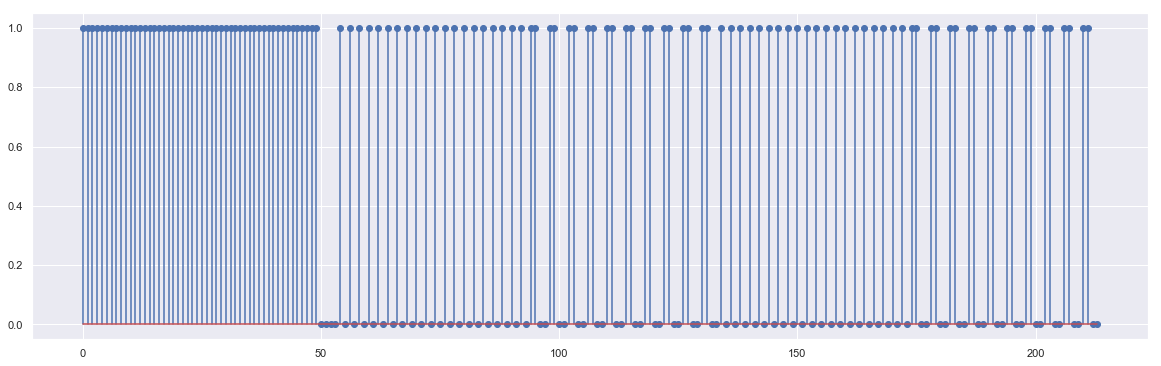

In [12]:
DP.plot_subset(
    DP.discretized_array, 
    start=DP.header_starts[0], 
    stop=DP.header_starts[0] + len(DP.header) + len(DP.data_msg) + 4
)

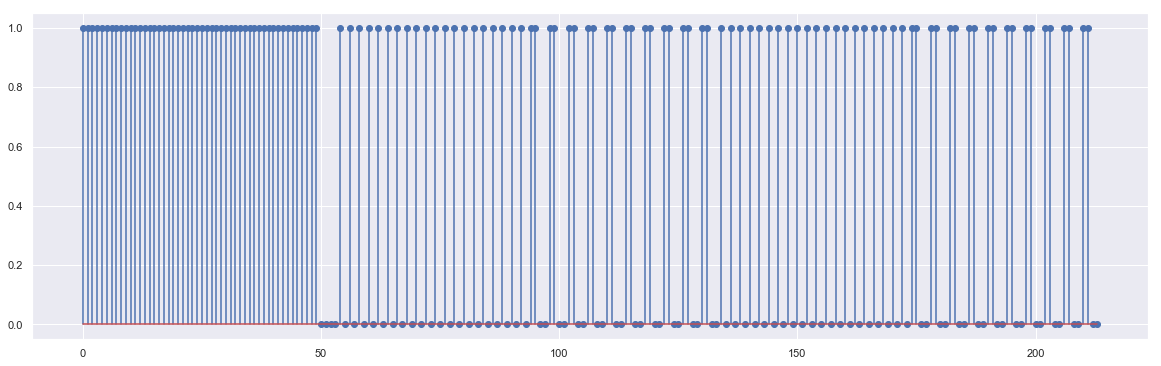

In [13]:
DP.plot_subset(
    DP.discretized_array, 
    start=DP.header_starts[25], 
    stop=DP.header_starts[25] + len(DP.header) + len(DP.data_msg) + 4
)

#### signal stats

In [11]:
DP.get_signal_stats(DP.data)

[(14, 39780),
 (10, 39722),
 (22, 19880),
 (26, 19877),
 (11, 14791),
 (13, 14733),
 (25, 7383),
 (23, 7380),
 (599, 1273),
 (49, 1190),
 (48, 173),
 (600, 90),
 (5, 1)]